In [1]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')
plt.rcParams.update({'font.size': 14})

INFO: Using numpy backend


In [2]:
# Paths
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs'
samples_dir = os.path.join(base_dir, 'samples')
sample_cluster_dir = os.path.join(base_dir, 'sample_clustering')
figure_dir = os.path.join(base_dir, 'figures')
train_align_dir = os.path.join(base_dir, 'train_align')
train_pdbs_dir = os.path.join(base_dir, 'training_pdbs')


base_protdiff_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/'

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_align_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(train_pdbs_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(sample_cluster_dir, exist_ok=True)



if len(os.listdir(base_dir)):
    print('WARNING: overwriting results!')

In [3]:
all_csvs = []
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2'
print(f'Reading samples from {results_dir}')
for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    for i,sample_name in enumerate(os.listdir(length_dir)):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            design_csv['length'] = int(sample_length.split('_')[1])
            design_csv['sample_id'] = i
            all_csvs.append(design_csv)
self_conditioned_df = pd.concat(all_csvs)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2


# Process results

In [4]:
def pick_path(x):
    if x.sample_path is None or x.sample_path == '':
        return x.of_path
    return x.sample_path

length_categories = [
    '60-100', '100-200', '200-300', '300-400', '400-500'
][::-1]
buckets = np.arange(0, 501, 100)

def df_process(raw_df):
    # Process sample path
    df = raw_df.copy()
    df['sample_path'] = df['sample_path'].fillna('')
    df['sample_path'] = df.apply(pick_path, axis=1)
    df['sequence_id'] = df['sample_path'].apply(lambda x: int(os.path.basename(x).replace('.pdb', '').split('_')[1]))
    
    # Separate based on whether MPNNed
    df['header'] = df['header'].fillna('')
    df = df[df['header'].map(lambda x: 'sde_1' not in x)]
    return df

def sc_filter(raw_df, metric):
    # Pick best self-consistency sample
    if metric == 'rmsd':
        df = raw_df.sort_values('rmsd', ascending=True)
    elif metric == 'tm':
        df = raw_df.sort_values('tm_score', ascending=False)
    else:
        raise ValueError(f'Unrecognized metric: {metric}')
    df = df.groupby(['length', 'sample_id']).first().reset_index()

    # Separate into different length groups
    df['length_group'] = df.length.map(lambda x: length_categories[np.sum(x <= buckets).item()-1])
    df['length_group'] = pd.Categorical(df['length_group'], ordered=True, categories=length_categories[::-1])

    # Calculate how designable
    cutoff = 0.5
    df['designable'] = df.tm_score.map(lambda x: x > cutoff)
    designable_df = pd.pivot_table(df, values='designable', index='length_group', aggfunc=np.mean).reset_index()
    percent_designable = df['designable'].mean()
    print(f'Percent designable: {percent_designable}')
    return df, designable_df


def process_pipeline(raw_df, metric):
    processed_df = df_process(raw_df)
    seq_8_df = processed_df[processed_df.sequence_id < 8]
    
    df, designable = sc_filter(processed_df, metric=metric)
    designable['Sequences'] = 100
    df['Sequences'] = 100
    df_8, designable_8 = sc_filter(seq_8_df, metric=metric)
    df_8['Sequences'] = 8
    designable_8['Sequences'] = 8
    samples_df = pd.concat([df, df_8], axis=0)
    designable_df = pd.concat([designable, designable_8], axis=0)
    return samples_df, designable_df


In [5]:
plt.rcParams.update({'font.size': 14})

def plot_sc_rmsd(df, save_path=None):
    rmsd_samples, _ = process_pipeline(df, metric='rmsd')
    
    p = sns.boxplot(
        data=rmsd_samples,
        x='length_group',
        y='rmsd',
        hue='Sequences',
        showfliers = False
    )

    plt.xlabel('Length group')
    plt.ylabel('scRMSD')
    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('ProteinMPNN \nsequences')
    plt.ylim(0.0, 25)
    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
def plot_sc_tm(df, save_path=None):
    tm_samples, tm_designable = process_pipeline(df, metric='tm')

    p = sns.boxplot(
        data=tm_samples,
        x='length_group',
        y='tm_score',
        hue='Sequences',
        showfliers = False
    )

    designable_numbers = tm_designable[tm_designable.Sequences == 8].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            1.0,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='blue',
            weight='semibold'
        )

    designable_numbers = tm_designable[tm_designable.Sequences == 100].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            0.95,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='orange',
            weight='semibold'
        )

    plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
    plt.ylim(0.0, 1.1)
    plt.xlabel('Length group')
    plt.ylabel('scTM')

    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('ProteinMPNN \nsequences')

    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Plot designable results

Percent designable: 0.6247191011235955
Percent designable: 0.4943820224719101


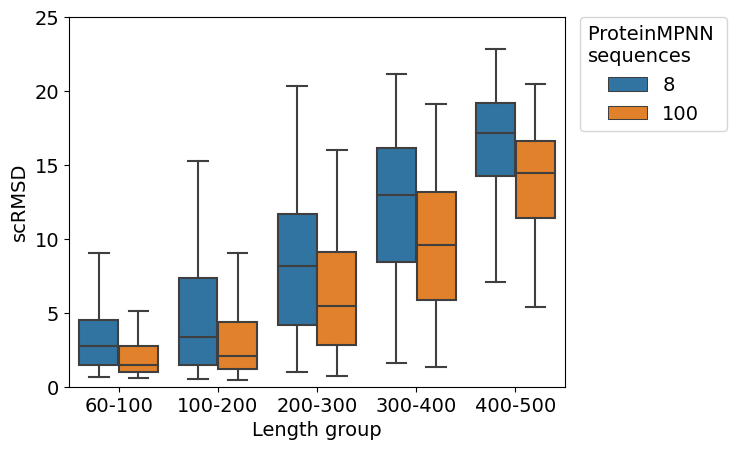

In [81]:
plot_sc_rmsd(self_conditioned_df, save_path='scrmsd_plot.png')

Percent designable: 0.6685393258426966
Percent designable: 0.5179775280898876


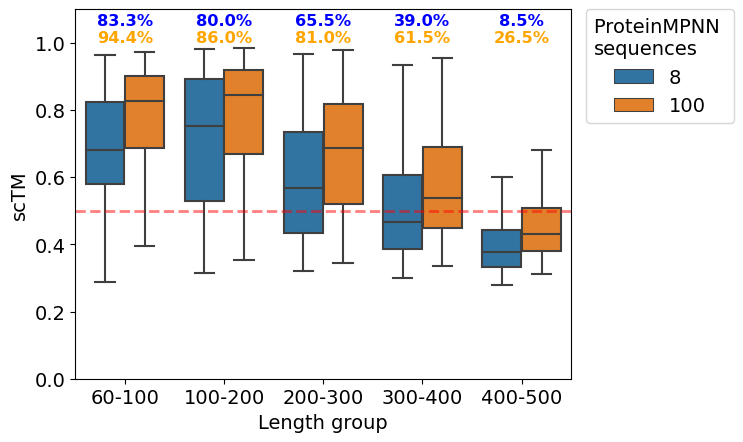

In [82]:
plot_sc_tm(self_conditioned_df, save_path='sctm_plot.png')

Percent designable: 0.6247191011235955
Percent designable: 0.4943820224719101


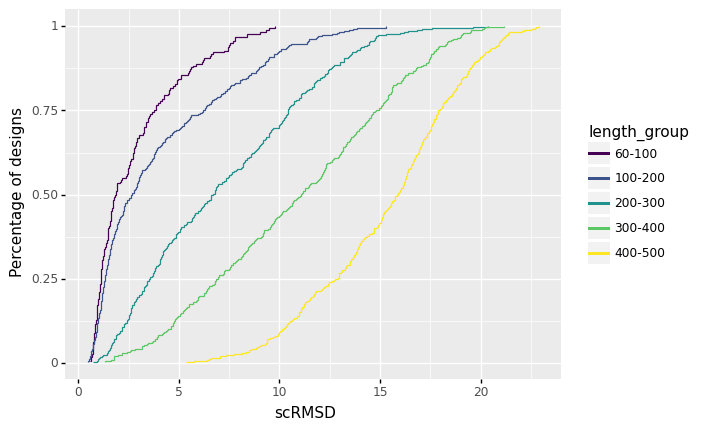

In [36]:
# Plot
rmsd_samples, _ = process_pipeline(self_conditioned_df, metric='rmsd')
p = (
    gg.ggplot(
        rmsd_samples,
        gg.aes('rmsd', color='length_group')
    )
    + gg.stats.stat_ecdf()
    # + gg.scales.scale_x_reverse()
    # + gg.geoms.geom_vline(
    #     xintercept=cutoff,
    #     size=1.0,
    #     linetype='dashed',
    #     color='red',
    # )
    + gg.labels.xlab('scRMSD')
    + gg.labels.ylab('Percentage of designs')
)

print(p)

# Save designable samples

In [38]:
tm_samples, _ = process_pipeline(self_conditioned_df, metric='tm')

Percent designable: 0.6685393258426966
Percent designable: 0.5179775280898876


In [39]:
designable_samples_df = tm_samples[tm_samples.designable]
designable_8_seq_smaples = designable_samples_df[designable_samples_df.Sequences == 8]
designable_100_seq_smaples = designable_samples_df[designable_samples_df.Sequences == 100]

In [ ]:
# Save all designable hallucination samples
fname = os.path.join(samples_dir, 'sc_pdbs.txt')
prefix = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2'
# prefix = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/13D_12M_2022Y_13h_43m_13s/'
with open(fname, 'w') as f:
    for _, row in designable_8_seq_smaples.iterrows():
        sample_path = row.sample_path
        full_path = os.path.join(base_protdiff_dir, sample_path)
        if 'hallucination/0' not in sample_path:
            full_path = full_path.replace('hallucination', 'hallucination/0')
        suffix = '/'.join(full_path.split('/')[-5:])
        full_path = os.path.join(prefix, suffix)
        file_name = f'length_{str(row.length)}_id_{str(row.sample_id)}.pdb'
        save_path = os.path.join(samples_dir, file_name)
        shutil.copy(full_path, save_path)
        f.write(save_path+'\n')

In [ ]:
# Paths
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs'
samples_dir = os.path.join(base_dir, 'samples')
sample_cluster_dir = os.path.join(base_dir, 'sample_clustering')
figure_dir = os.path.join(base_dir, 'figures')
train_align_dir = os.path.join(base_dir, 'train_align')
train_pdbs_dir = os.path.join(base_dir, 'training_pdbs')


base_protdiff_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/'

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_align_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(train_pdbs_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(sample_cluster_dir, exist_ok=True)



if len(os.listdir(base_dir)):
    print('WARNING: overwriting results!')

In [ ]:
# Save all designable hallucination samples
fname = os.path.join(samples_dir, 'sc_pdbs.txt')
prefix = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2'
# prefix = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/13D_12M_2022Y_13h_43m_13s/'
with open(fname, 'w') as f:
    for _, row in designable_100_seq_smaples.iterrows():
        sample_path = row.sample_path
        full_path = os.path.join(base_protdiff_dir, sample_path)
        if 'hallucination/0' not in sample_path:
            full_path = full_path.replace('hallucination', 'hallucination/0')
        suffix = '/'.join(full_path.split('/')[-5:])
        full_path = os.path.join(prefix, suffix)
        file_name = f'length_{str(row.length)}_id_{str(row.sample_id)}.pdb'
        save_path = os.path.join(samples_dir, file_name)
        shutil.copy(full_path, save_path)
        f.write(save_path+'\n')

# Compare with RFdiffusion

In [80]:
all_csvs = []
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_rfdiff_benchmark'
print(f'Reading samples from {results_dir}')
for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    for i,sample_name in enumerate(os.listdir(length_dir)):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            design_csv['length'] = int(sample_length.split('_')[1])
            design_csv['sample_id'] = i
            all_csvs.append(design_csv)
benchmark_df = pd.concat(all_csvs)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_rfdiff_benchmark


In [90]:
# Format RF diffusion samples
s2f_df = pd.read_csv('S2F_data.csv')
s2f_df['Unconditional'] = s2f_df.problem.apply(lambda x: 'uncond' in x)
rfdiff_samples_df = s2f_df[s2f_df['Unconditional']]
metric = 'rmsd_af2_des'
df_temp = rfdiff_samples_df.sort_values(metric)
df_temp = df_temp.drop_duplicates('name')

cols = [
    'rmsd_af2_des',
    'problem',
    'random',
]
formatted_rf_diff = {
    'length': rfdiff_samples_df.problem.apply(lambda x: int(x.split('_')[1])),
    'rmsd': rfdiff_samples_df.rmsd_af2_des,
    'model': rfdiff_samples_df.random.map({
        'Outputs without Pre-Training': 'RFDiffusion \nw/o pretraining',
        'Outputs with Pre-Training': 'RFDiffusion',
    }),
}
formatted_rf_diff = pd.DataFrame(formatted_rf_diff)


/tmp/ipykernel_1855323/3899596801.py:2: DtypeWarning: Columns (98,118,119,121,122,127,133,134,135,139,140) have mixed types. Specify dtype option on import or set low_memory=False.


In [91]:
# Format FrameDiff samples
# rmsd_samples, _ = process_pipeline(refolded_df, metric='rmsd')
rmsd_samples, _ = process_pipeline(benchmark_df, metric='rmsd')
rmsd_seq_8_samples = rmsd_samples[rmsd_samples.Sequences == 8]
formatted_framediff = rmsd_seq_8_samples[['length', 'rmsd']]
formatted_framediff = formatted_framediff[formatted_framediff.length.isin([70, 100, 200, 300])]
formatted_framediff['model'] = 'FrameDiff'

Percent designable: 0.6802083333333333
Percent designable: 0.6703125


In [92]:
formatted_df = pd.concat([formatted_rf_diff, formatted_framediff], axis=0)

In [95]:
order = ['RFDiffusion \nw/o pretraining', 'FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = formatted_df,
    hue = 'model',
    hue_order=order,
    showfliers = False
)

# plt.ylim(0.0, 1.1)
# plt.show()
plt.xlabel('Length')
plt.ylabel('scRMSD')
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
ax.legend_.set_title('Method')
# plt.show()
plt.savefig('rfdiffusion_benchmark.png', bbox_inches='tight')

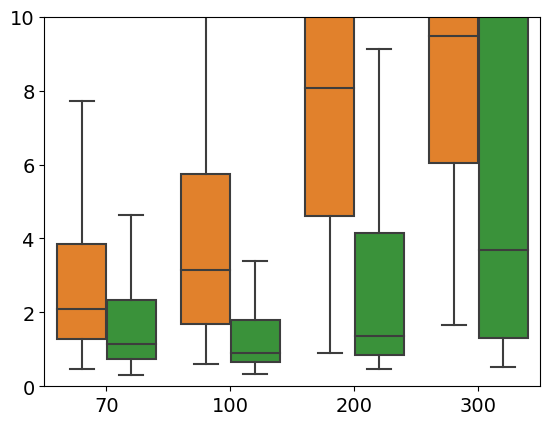

In [17]:
zoomed_df = formatted_df[formatted_df.model.isin(['FrameDiff', 'RFDiffusion'])]
order = ['FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = zoomed_df,
    hue = 'model',
    hue_order=order,
    showfliers = False,
    palette = ['#ff7f0e', '#2ca02c']
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.ylim(0.0, 10)
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
legend.remove()
plt.savefig('rfdiffusion_benchmark.png')


# Clustering

In [6]:
file = os.path.join(sample_cluster_dir, 'all_by_all_lite')
with open(file, 'r') as f:
    text = f.read()
    
    size = re.findall(r'SIZE :(.*\d+)', text)[0]
    size = int(size)
    
    id_to_filename = {}
    D = np.ones((size,size))
    for line in text.splitlines():
        if line[:3] == 'PDB':
            _, id_, filename = line.split()
            id_ = int(id_)
            id_to_filename[id_] = filename
        elif line[:2] == 'MS':
            _, _, idx1, idx2, tm1, tm2, pairs = line.split()
            i, j = int(idx1)-1, int(idx2)-1
            tm1, tm2 = float(tm1), float(tm2)
            tm_mean = (tm1 + tm2) / 2
            D[i, j] = 1 - tm1
            D[j, i] = 1 - tm2
D_mean = (D + D.T) / 2
    

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 200x200 with 0 Axes>

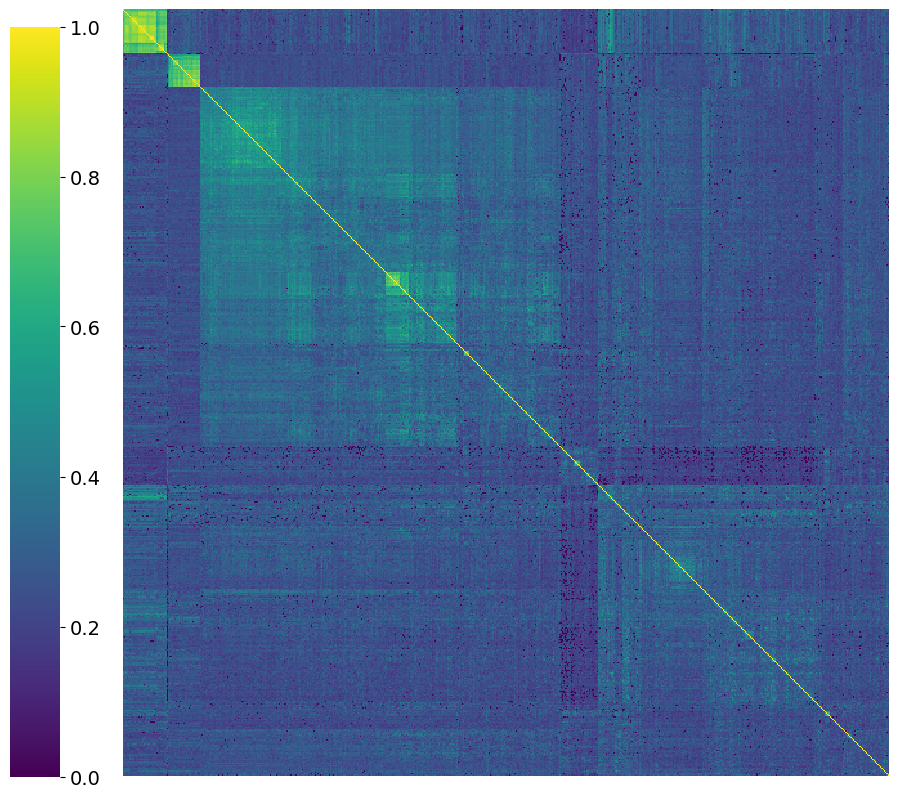

In [52]:
plt.figure(figsize=(2,2))
g = sns.clustermap(
    1 - D_mean,
    method='average',
    figsize=(10,10),
    yticklabels=False,
    xticklabels=False,
    cbar_pos=(0.1, 0.02, 0.05, 0.75),
    cmap='viridis'
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# plt.show()
plt.savefig(os.path.join(figure_dir, 'unconditional_sample_clustering.png'))

# Align samples to training PDBs

In [7]:
def process_lines(line):
    cleaned_lines = line.replace('\n', '')
    pdb_name, tm_score = cleaned_lines.split(' ')
    return pdb_name, float(tm_score)

In [8]:
all_results = defaultdict(list)
for x in os.listdir(train_align_dir):
    output_path = os.path.join(train_align_dir, x)
    if 'tar' in output_path:
        continue
    with open(output_path) as f:
        for i,line in enumerate(f):
            try:
                l = process_lines(line)
                all_results[x].append(l)
            except Exception as e:
                continue

In [9]:
alignment_df = {
    'length': [],
    'sample_id': [],
    'top_hit': [],
    'top_hit_score': []
}
for example_id, example_alignments in all_results.items():
    length = int(example_id.split('_')[1])
    sample_id = int(example_id.split('_')[-1])
    alignment_df['length'].append(length)
    alignment_df['sample_id'].append(sample_id)
    top_hit, top_hit_score = example_alignments[0]
    alignment_df['top_hit'].append(top_hit)
    alignment_df['top_hit_score'].append(top_hit_score)
alignment_df = pd.DataFrame(alignment_df)

In [10]:
tm_samples, _ = process_pipeline(self_conditioned_df, metric='tm')
designable_samples_df = tm_samples[tm_samples.designable]
designable_8_seq_samples = designable_samples_df[designable_samples_df.Sequences == 8]
designable_100_seq_samples = designable_samples_df[designable_samples_df.Sequences == 100]

Percent designable: 0.6685393258426966
Percent designable: 0.5179775280898876


In [11]:
aligned_df = designable_100_seq_samples.merge(alignment_df, on=['length', 'sample_id'])

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 129 rows containing missing values.


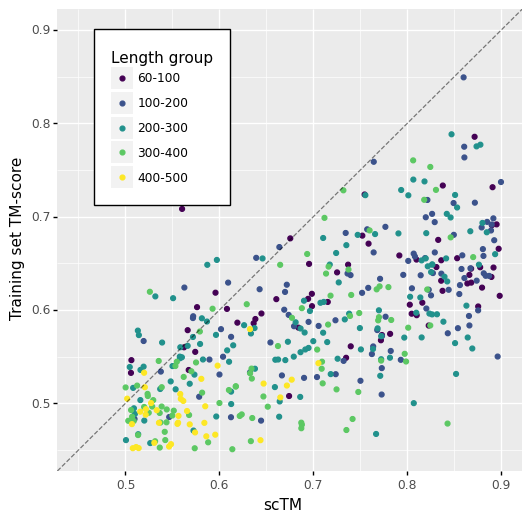

In [12]:
# Plot
p = (
    gg.ggplot(
        aligned_df,
        gg.aes('tm_score', 'top_hit_score', color='length_group')
    )
    + gg.geom_point()
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Training set TM-score')
    + gg.labels.labs(color='Length group')
    + gg.scales.ylim(0.45, 0.90)
    + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        figure_size=(6, 6),
        legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black')
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
)

print(p)

# Link clusters with PDB similarity

In [100]:
with open('/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_8_seqs/sample_clustering/maxcluster_results.txt', 'r') as f:
    capture = False
    centroid_lines = []
    for line in f.read().splitlines():
        if capture:
            centroid_lines.append(line)
        if 'INFO  : Cluster  Centroid  Size        Spread' in line:
            capture = True
            
centroid_lines = centroid_lines[:-1]

data = {'Cluster size': [], 'path': [], 'length': [], 'sample_id': []} #, 'tm_v_pdb100': []}
for line in centroid_lines:
    line = line.split()
    cluster_size = line[5]
    path = line[7]
    filename = os.path.basename(path).replace('.pdb', '')
    data['Cluster size'].append(int(cluster_size))
    data['path'].append(path)
    data['length'].append(int(filename.split('_')[1]))
    data['sample_id'].append(int(filename.split('_')[3]))

clusters_df = pd.DataFrame(data)

In [101]:
centroid_df = aligned_df.merge(clusters_df, on=['length', 'sample_id'])

In [99]:
designable_8_seq_samples.shape

(461, 11)

In [98]:
401/595

0.6739495798319328

In [103]:
centroid_df.shape

(289, 15)

In [104]:
289 / 461

0.6268980477223427

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



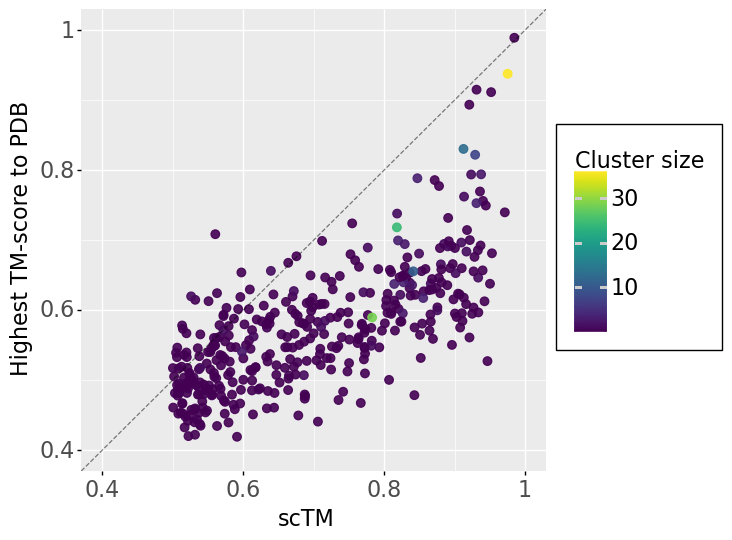

In [15]:
# Plot
p = (
    gg.ggplot(
        centroid_df,
        gg.aes(
            'tm_score',
            'top_hit_score',
            color='Cluster size',
            # marker='Cluster size'
      )
    )
    + gg.geom_point(
        size=3,
        alpha=0.9
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.themes.theme(
        figure_size=(6, 6),
        # legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        text=gg.element_text(size=16)
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
    + gg.scale_y_continuous(breaks = np.linspace(0.2, 1.0, 7))
    + gg.scale_x_continuous(breaks = np.linspace(0.4, 1.0, 7))
    + gg.scales.xlim(0.40, 1.0)
    + gg.scales.ylim(0.40, 1.0)
)

print(p)

In [16]:
# p.save(filename='pdb_align.png', dpi=300)

In [ ]:
sorted_df = centroid_df.sort_values('tm_score', ascending=False)
novel_df = sorted_df[sorted_df.top_hit_score < 0.6]

In [17]:
# novel_df.head()

In [ ]:
/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2/length_240/sample_9/mpnn/esmf/sample_93.pdb

/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2/length_380/sample_9/mpnn/esmf/sample_41.pdb

/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2/length_145/sample_0/mpnn/esmf/sample_85.pdb

In [ ]:
# TODO: Run ESMFold over all these designs to get their pLDDT.

In [23]:
all_sample_sequences = centroid_df.sequence
all_sample_paths = centroid_df.path

In [ ]:
all_sample_sequences.iloc[0]

In [18]:
import esm

In [20]:
torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')

In [24]:
folding_model = esm.pretrained.esmfold_v1().eval()
folding_model = folding_model.to('cuda')

In [26]:
with torch.no_grad():
    output = folding_model.infer_pdb(all_sample_sequences.iloc[0])

'/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_60_id_0.pdb'

In [36]:
all_plddt = {}
for i,path in enumerate(centroid_df.path):
    sample_feats = du.parse_pdb_feats('sample', path)
    all_plddt[path] = sample_feats['b_factors'][:, 1]
    if i % 100 == 0:
        print(i)

0
100
200
300
400


In [38]:
centroid_df['pLDDT'] = centroid_df.path.apply(lambda x: np.mean(all_plddt[x]))

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



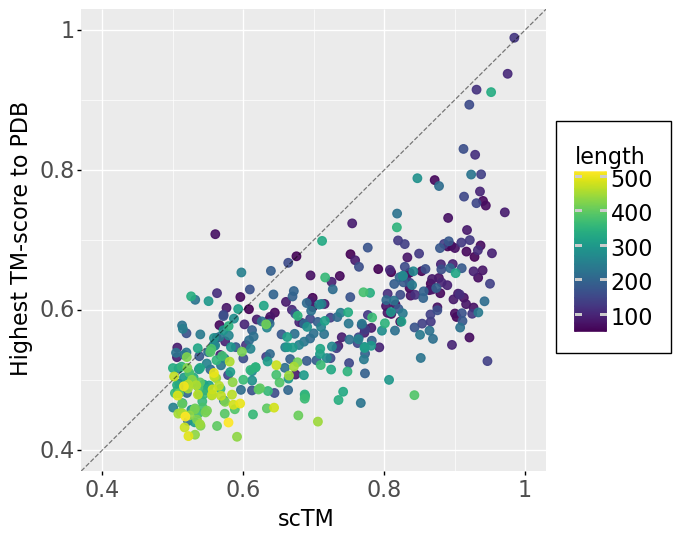

In [78]:
# Plot
p = (
    gg.ggplot(
        centroid_df,
        gg.aes(
            'tm_score',
            'top_hit_score',
            color='length',
            # color='pLDDT',
            # marker='Cluster size'
      )
    )
    + gg.geom_point(
        size=3,
        alpha=0.9
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.themes.theme(
        figure_size=(6, 6),
        # legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        text=gg.element_text(size=16)
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
    + gg.scale_y_continuous(breaks = np.linspace(0.2, 1.0, 7))
    + gg.scale_x_continuous(breaks = np.linspace(0.4, 1.0, 7))
    + gg.scales.xlim(0.40, 1.0)
    + gg.scales.ylim(0.40, 1.0)
)

print(p)

In [79]:
p.save(filename='pdb_align.png', dpi=300)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: pdb_align.png


In [76]:
sorted_df = centroid_df.sort_values('tm_score', ascending=False)
sorted_df = sorted_df.sort_values('length', ascending=False)
novel_df = sorted_df[(sorted_df.top_hit_score < 0.7) & (sorted_df.pLDDT > 70)]

In [77]:
novel_df.head(20)

,length,sample_id,tm_score,sample_path,header,sequence,rmsd,sequence_id,length_group,designable,Sequences,top_hit,top_hit_score,Cluster size,path,pLDDT
289,320,2,0.901405,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/31D_12M_2022Y_17h_41m_44s/length_320/sample_5/mpnn/esmf/sample_59.pdb,"T=0.1, sample=59, score=1.0484, global_score=1.0484, seq_recovery=0.0906",MEEKREKLEESIESFNSEEVEKKFKEAEENGNYEEWFEYAVELLEKARSPENVGLAVLIFRLMLKSKGEEARRRFLRALVTPEFRELMKHVFALAGDWPNEDIIDFLARVLGDPEIDPDDALAFVLDALEVMKESLPRETLTELFRRIGFENKEPRAAEALARLVEELLAKTKELTPEDRKLLAAAGGGLILGGAGFDPEKGRRWAEWFLSLPLEEENFREALKRAYEEGDSEEAYEFLLEVAEKYDKEFGIELYIEKKAKKEKEKPEIDENFLKEFLELDKKYNINKEKIANIVKEFGKKAKKEEEKEIIKKYLKIYTE,2.072854,59,300-400,True,100,6fvb_A,0.65264,2,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_320_id_2.pdb,74.422156
252,270,6,0.826444,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_270/sample_3/mpnn/esmf/sample_34.pdb,"T=0.1, sample=34, score=0.9703, global_score=0.9703, seq_recovery=0.2148",MECGDWSAEERQALIREAMATDPKKGGVECLKCAKALVEKGRSATALAWYEELMPFLDQMSPELAAEATDAYFELLKDTDVDRAVEVALRGFASGGAAGLVGADKGLAIGLNPDLDPELAERLAEAMWAVAQQPEEGNIGGAIGVALFGLDRPEGRERALEGARLAAADPRHPEFGALWLEVAEAVAFRPDVVGAAAELGERTGNELVEAVGCAFGATLAPERPGAFPALLEAFARCARNPSYGELARRLLARVAAEGGGPAALAARAAP,2.792809,34,200-300,True,100,6sl1_A,0.64880,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_270_id_6.pdb,70.039333
153,185,0,0.910066,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_185/sample_7/mpnn/esmf/sample_9.pdb,"T=0.1, sample=9, score=0.9926, global_score=0.9926, seq_recovery=0.1838",GGAAARAARLEAIIAEFAARAGPAMAEGLRAVLARAAAGASPAEVGAALLEEVGRGEGPAGFEAGVAVGAALGRPEEFAKYLEEHRPFGLLKRALEEKDYEKGIKIAKEALKQYSKGEGEAGLEKLKKLLELLLEMAKEGPLETQKAVEELFKELVKLIEKKLGPEFGKKLLEELKKELEKIKAE,1.471142,9,100-200,True,100,3k8p_D,0.65970,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_185_id_0.pdb,72.719027
150,180,3,0.891645,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_180/sample_0/mpnn/esmf/sample_4.pdb,"T=0.1, sample=4, score=1.0556, global_score=1.0556, seq_recovery=0.2833",SRRRWLAIATLVVFLLELIVAATAALAPLYLRRGPLLGTLVLLLVGAGADLLGEALLGLATGRWAVAAAGAAVTLFSAVGFALGLLLLGLSRRFGDWSPAVRALLAAAAAAAAAAWAATGPLGPDDPGAGLLALAHATAAALLGVAAAAADFGVLCAAEVAAELLYGLAVLLWGLRLARR,2.410424,4,100-200,True,100,7jh5_B,0.69821,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_180_id_3.pdb,73.381778
139,170,0,0.910251,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_170/sample_6/mpnn/esmf/sample_6.pdb,"T=0.1, sample=6, score=1.0163, global_score=1.0163, seq_recovery=0.1176",GSHMEEEGEKIKEEIEKFVESNKDKDPIEIAKEAVEKAIELSKNKTYKGAVLAFAKILELLPESKAIAKELAAKLASSFKGSIGTVRRLLKEAGFDEAIIEAALEAIKNRPGEFFIEALEKSRDLSCEDFFENLELEREYGEKVSGEEILAKIDELRAERRASGCVDPLN,1.437282,6,100-200,True,100,3icq_T,0.59540,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_170_id_0.pdb,83.955529
135,165,5,0.764186,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_165/sample_6/mpnn/esmf/sample_5.pdb,"T=0.1, sample=5, score=1.0916, global_score=1.0916, seq_recovery=0.1879",AALLAALLAALAATIVAGLFGPLWEAGMAAARVVGALLAGGKGLEVIAAAIVAKKGRPEEGYKAVLEAIKGGNTSLAGCRAAFEVAHLFSEEKRKEIKEVLKSKKNGCQPLFDEEAKKEAEELLKGGKSVEEIAKWVKKTGCKECEKWAEKKLKEAKLKELAKLL,2.921147,5,100-200,True,100,7dl2_A,0.66171,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_165_id_5.pdb,73.159394
131,160,7,0.829276,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_160/sample_2/mpnn/esmf/sample_47.pdb,"T=0.1, sample=47, score=0.9262, global_score=0.9262, s

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



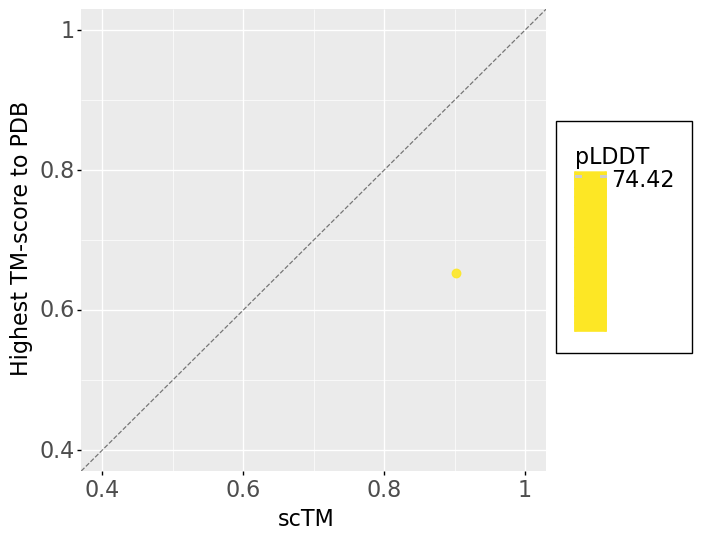

In [71]:
# Plot
p = (
    gg.ggplot(
        novel_df.head(1),
        gg.aes(
            'tm_score',
            'top_hit_score',
            color='pLDDT',
            # marker='Cluster size'
      )
    )
    + gg.geom_point(
        size=3,
        alpha=0.9
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.themes.theme(
        figure_size=(6, 6),
        # legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        text=gg.element_text(size=16)
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
    + gg.scale_y_continuous(breaks = np.linspace(0.2, 1.0, 7))
    + gg.scale_x_continuous(breaks = np.linspace(0.4, 1.0, 7))
    + gg.scales.xlim(0.40, 1.0)
    + gg.scales.ylim(0.40, 1.0)
)

print(p)